# Прогнозирование цены жилья в Мельбурне
Источник данных: https://www.kaggle.com/datasets/dansbecker/melbourne-housing-snapshot

In [1]:
# pip install haversine

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None) # показывать все колонки, не скрывать середину

import numpy as np
import scipy.stats as sts
from haversine import haversine # функция для подсчета расстояния между объектами

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8, 6) # размер графиков
%config InlineBackend.figure_format = 'retina' # чтобы графики были четкие

import seaborn as sns
sns.set_style('whitegrid') # сетка на графиках
sns.set_palette('cubehelix') # красивая палитра!

# для преобразования данных в регрессии:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
# для создания алгоритма, который объединяет преобразование катег. и непр. признаков:
from sklearn.compose import ColumnTransformer
# для создания алгоритма, который объединяет преобразование признаков и модель:
from sklearn.pipeline import Pipeline
# для разбиения на трейн-тест и кросс-валидации
from sklearn.model_selection import train_test_split, GridSearchCV
# модели машинного обучения:
from sklearn.linear_model import LinearRegression, Ridge
# метрика для оценивания модели:
from sklearn.metrics import mean_squared_error

%run functions.py
import functions

In [3]:
df = pd.read_csv('melb_data.csv')
df.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,2.0,1.0,1.0,202.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,2.0,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,3.0,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,3.0,2.0,1.0,94.0,NaN,NaN,Yarra,-37.7969,144.9969,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,3.0,1.0,2.0,120.0,142.0,2014.0,Yarra,-37.8072,144.9941,Northern Metropolitan,4019.0


In [4]:
df.shape # размерность данных

(13580, 21)

## Предварительная обработка данных

In [5]:
df.nunique() # количество уникальных значений в каждой колонке

Suburb             314
Address          13378
Rooms                9
Type                 3
Price             2204
Method               5
SellerG            268
Date                58
Distance           202
Postcode           198
Bedroom2            12
Bathroom             9
Car                 11
Landsize          1448
BuildingArea       602
YearBuilt          144
CouncilArea         33
Lattitude         6503
Longtitude        7063
Regionname           8
Propertycount      311
dtype: int64

__Номинальные:__
- Address (адрес)
- CouncilArea (администрация)
- Postcode (почтовый индекс)
- SellerG (агент)
- Suburb (округ)

__Категориальные:__
- Type (тип жилья)
- Method (как продано жилье)
- Regionname (регион)

__Непрерывные:__
- Rooms (количество комнат)
- Price (цена в долларах)
- Distance (расстояние до CBD, т.е. до делового центра города)
- Bedroom2 (количество спален)
- Bathroom (количество ванных)
- Car (количество парковочных мест)
- Landsize (площадь земли)
- Building area (площадь здания)
- Yearbuilt (год постройки)
- Propertycount (количество объектов собственности в округе)

__Вспомогательные:__
- Date (дата продажи)
- Lattitude (широта)
- Longitude (долгота)

In [6]:
nom = ['Address', 'CouncilArea', 'Postcode', 'SellerG', 'Suburb'] # номинальные
cat = ['Type', 'Method', 'Regionname'] # категориальные
num = ['Rooms', 'Price', 'Distance', 'Bedroom2', 'Bathroom', 'Car',
       'Landsize', 'BuildingArea', 'YearBuilt', 'Propertycount'] # числовые
fictive = ['Date', 'Lattitude','Longtitude'] # вспомогательные (на будущее)

In [7]:
df.drop(columns=nom, inplace=True) # удаляем номинальные, они не несут смысла

In [8]:
df.isna().sum() # количество пропусков в каждой колонке

Rooms               0
Type                0
Price               0
Method              0
Date                0
Distance            0
Bedroom2            0
Bathroom            0
Car                62
Landsize            0
BuildingArea     6450
YearBuilt        5375
Lattitude           0
Longtitude          0
Regionname          0
Propertycount       0
dtype: int64

Пропусков много в переменных, которые характеризуют площадь жилья и год постройки. Это важные характеристики, которые напрямую влияют на ценообразование, поэтому мы удалим пропуски. Выборка все равно останется большой, поэтому это позволительно. Также пропуски есть в переменной Car, но их совсем немного и точно можно удалить.

In [9]:
df.dropna(inplace=True) # удаляем пропуски

In [10]:
df.shape # размерность данных после удаления пропусков

(6830, 16)

### Изучение категориальных переменных

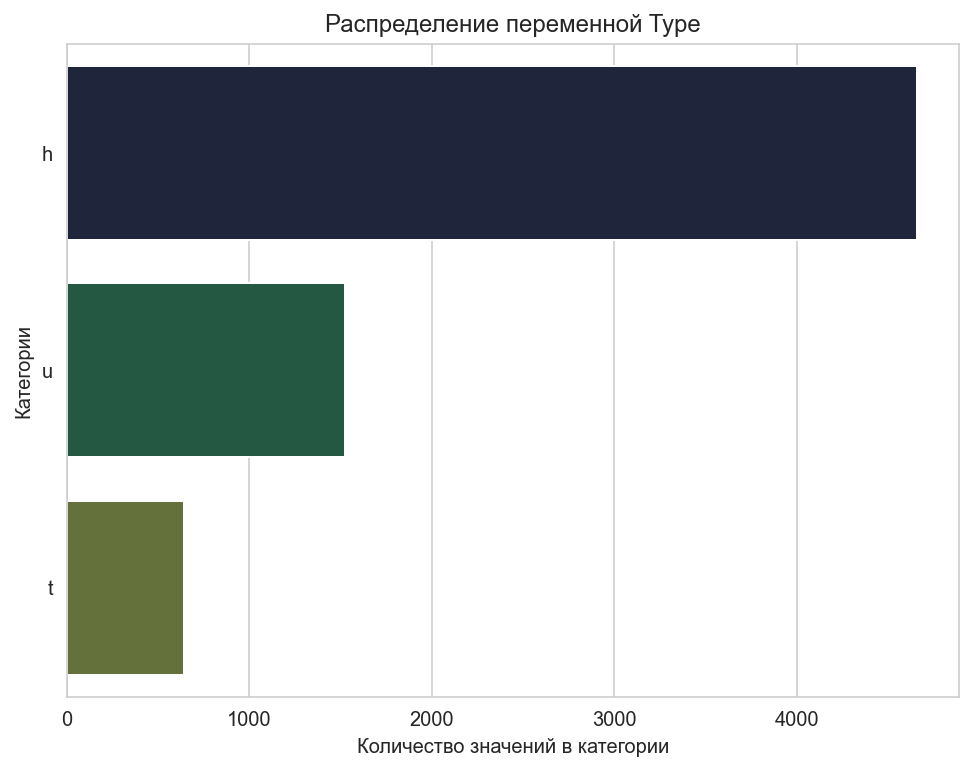

In [11]:
# plot_countplot - авторская функция, вынесенная в отдельный модуль
plot_countplot(df, 'Type') # сколько объектов в каждой категории у Type

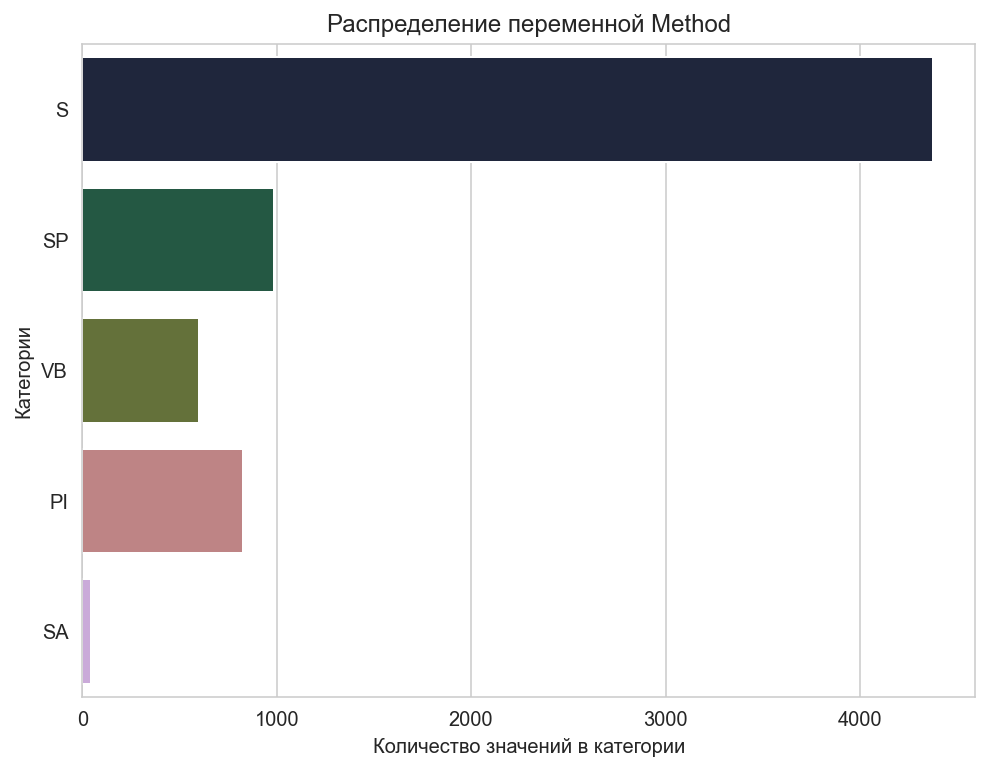

In [12]:
plot_countplot(df, 'Method') # сколько объектов в каждой категории у Method

In [13]:
df = df[df['Method'] != 'SA'] # удаляем незначительную категорию SA
df.shape # размерность данных после удаления категорий

(6786, 16)

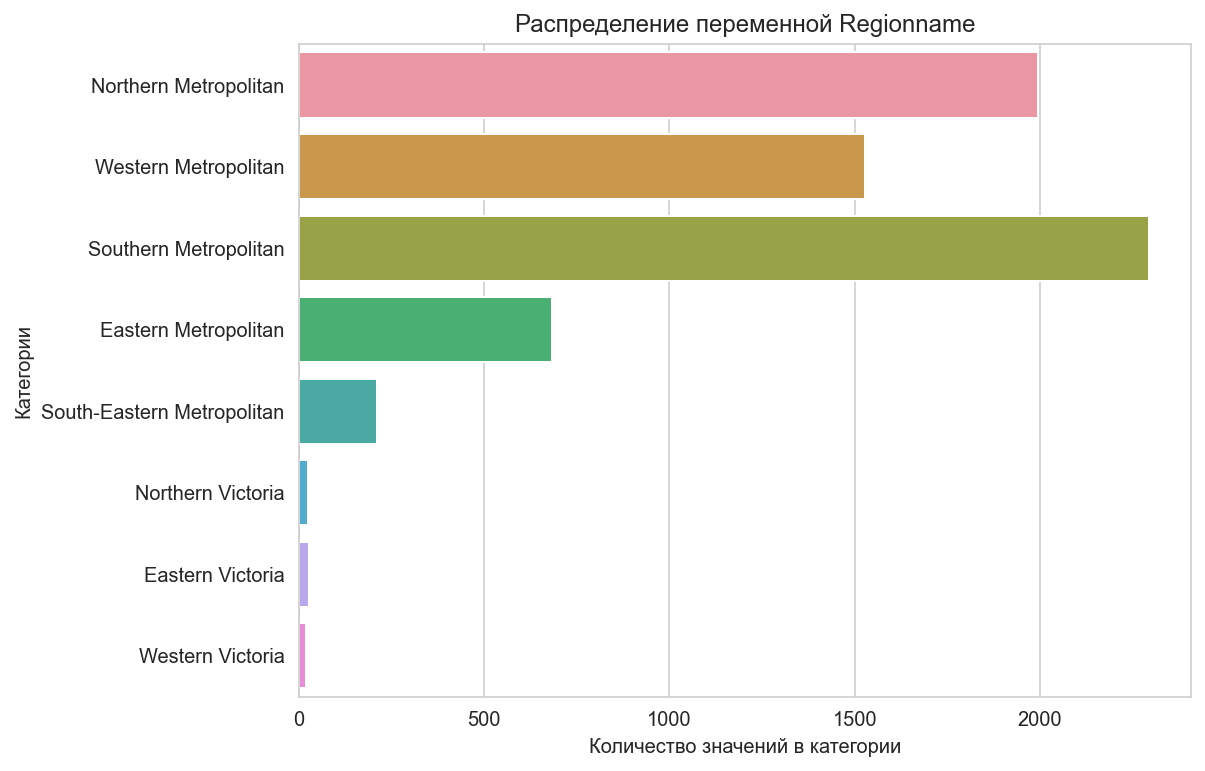

In [14]:
plot_countplot(df, 'Regionname') # сколько объектов в каждой категории у Regionname

In [15]:
# удаляем незначительные категории Northern Victoria, Eastern Victoria, Western Victoria
df = df[(df['Regionname'] != 'Northern Victoria') &
        (df['Regionname'] != 'Eastern Victoria') &
        (df['Regionname'] != 'Western Victoria')]
df.shape # размерность данных после удаления категорий

(6714, 16)

### Изучение непрерывных переменных

Посмотрим на распределения данных и выловим выбросы с помощью гистограмм.

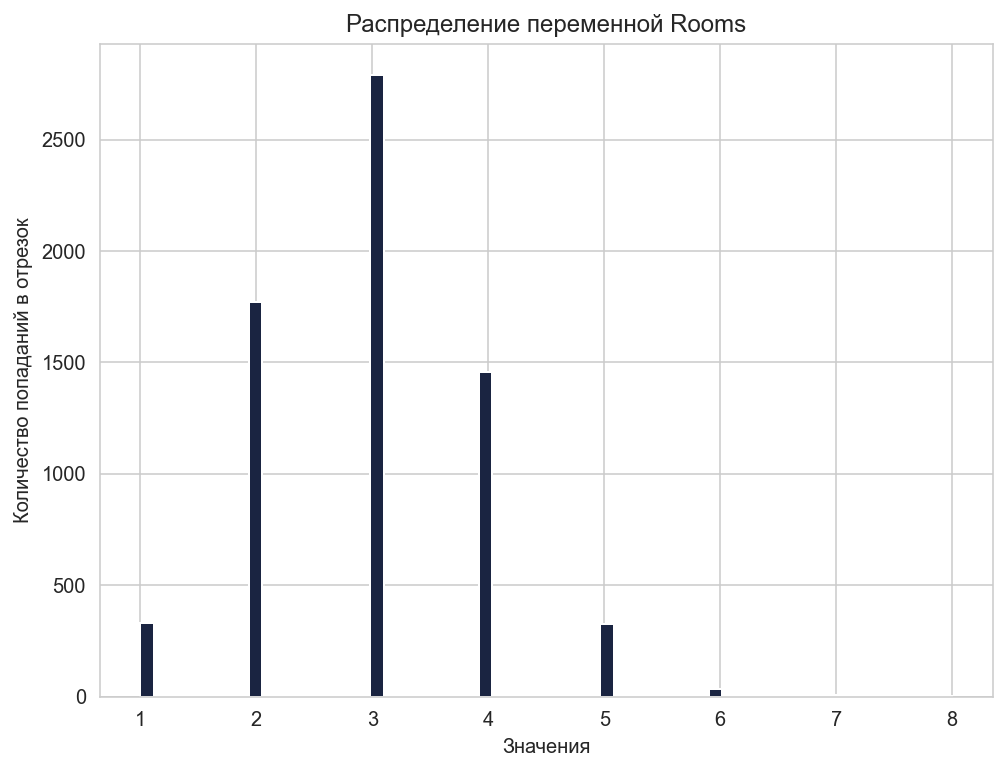

In [16]:
# plot_hist - авторская функция, вынесенная в отдельный модуль
plot_hist(df, 'Rooms') # количество комнат

In [17]:
len(df[df['Rooms'] > 6]) # мало наблюдений, больших 6

10

In [18]:
df = df[df['Rooms'] <= 6] # оставляем только те объекты, для которых значение Room <= 6

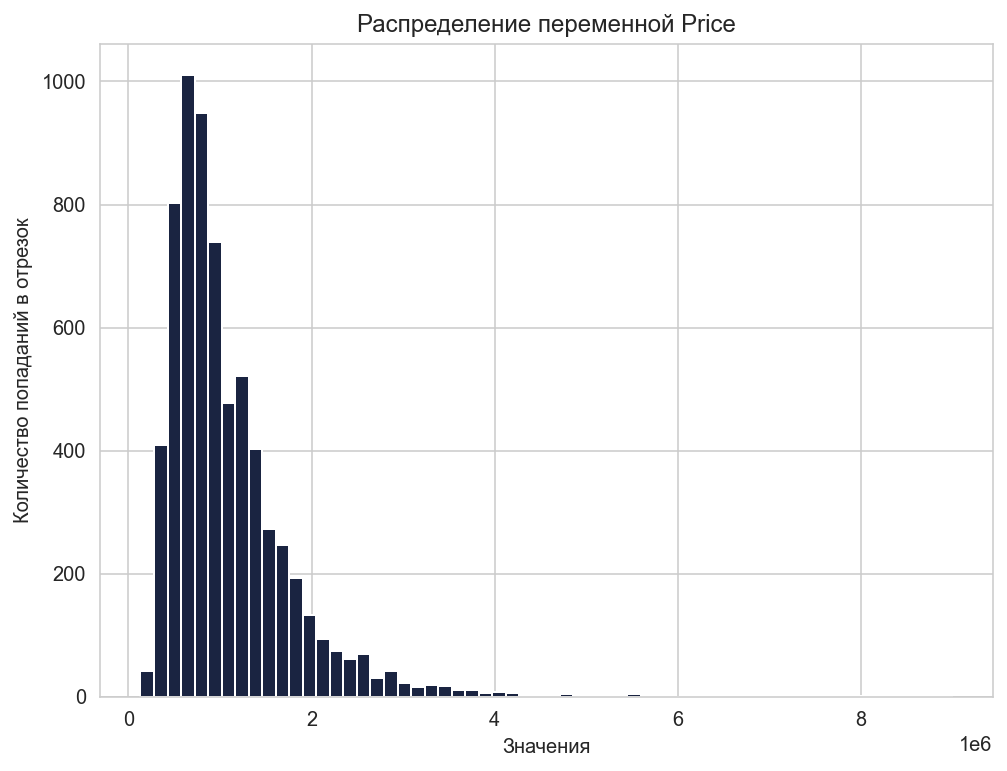

In [19]:
plot_hist(df, 'Price') # цена

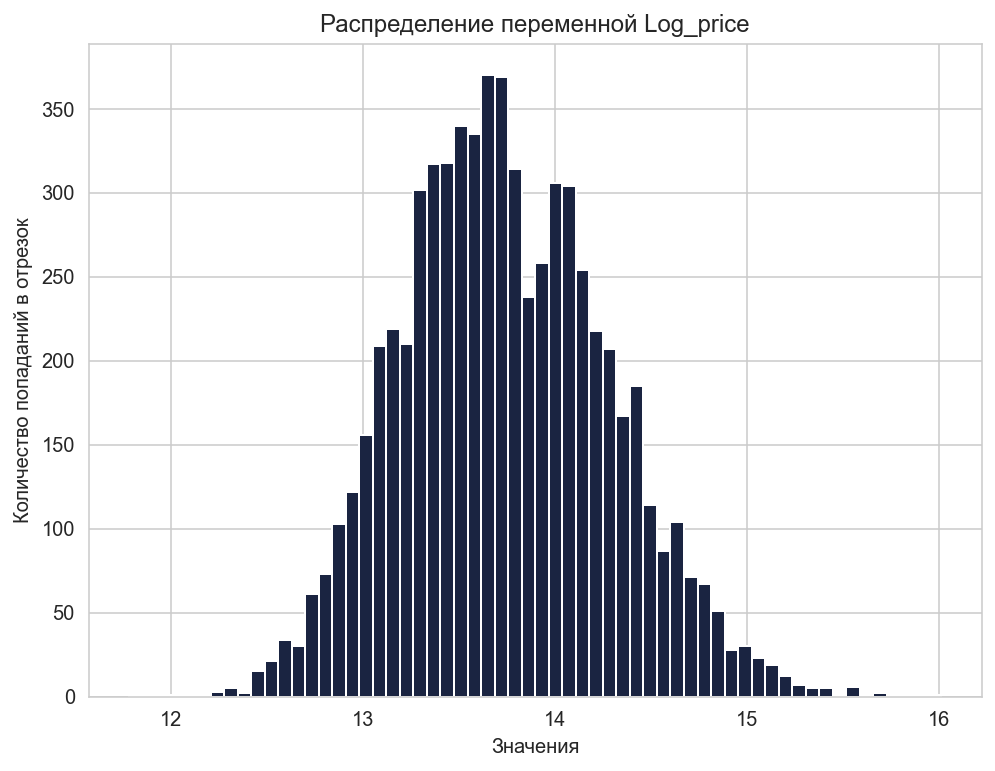

In [20]:
df['Log_price'] = np.log1p(df['Price']) # логарифмируем, добавляя единичку, т.е. делаем ln(1 + X)
plot_hist(df, 'Log_price') # логарифм цены

Распределение гораздо больше похоже на нормальное, поэтому цену заменим на логарифм цены.

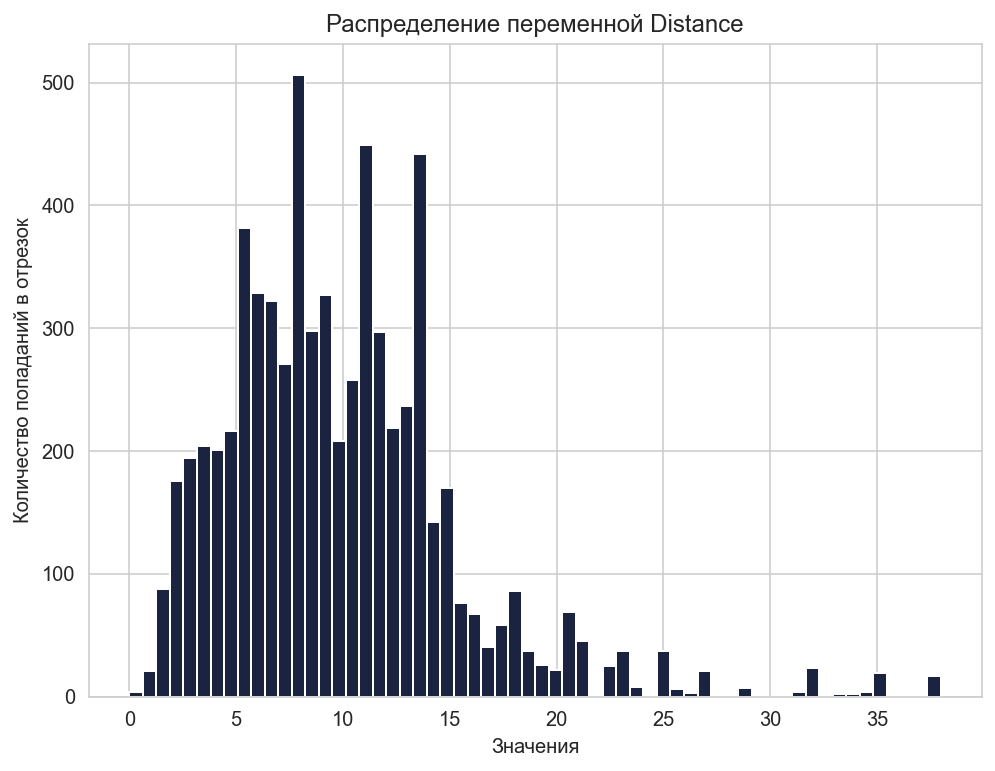

In [21]:
plot_hist(df, 'Distance') # расстояние до центра города

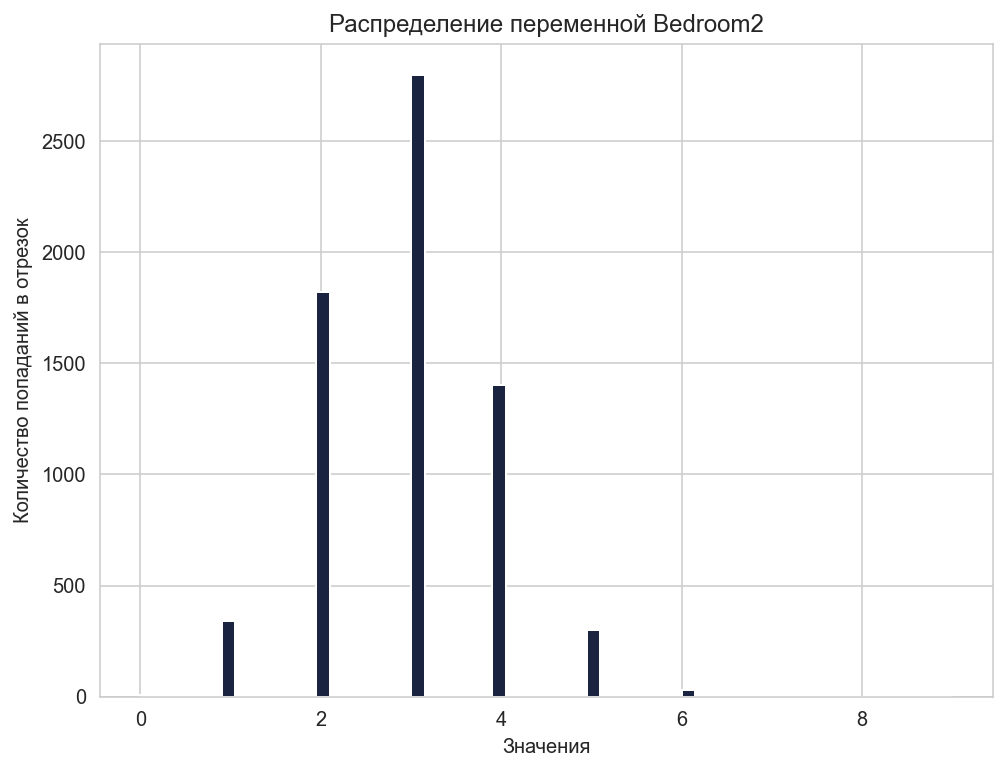

In [22]:
plot_hist(df, 'Bedroom2') # количество спален

In [23]:
len(df[df['Bedroom2'] > 6]) # мало наблюдений, больших 6

2

In [24]:
df = df[df['Bedroom2'] <= 6] # оставляем только те объекты, для которых значение Bedroom2 <= 6

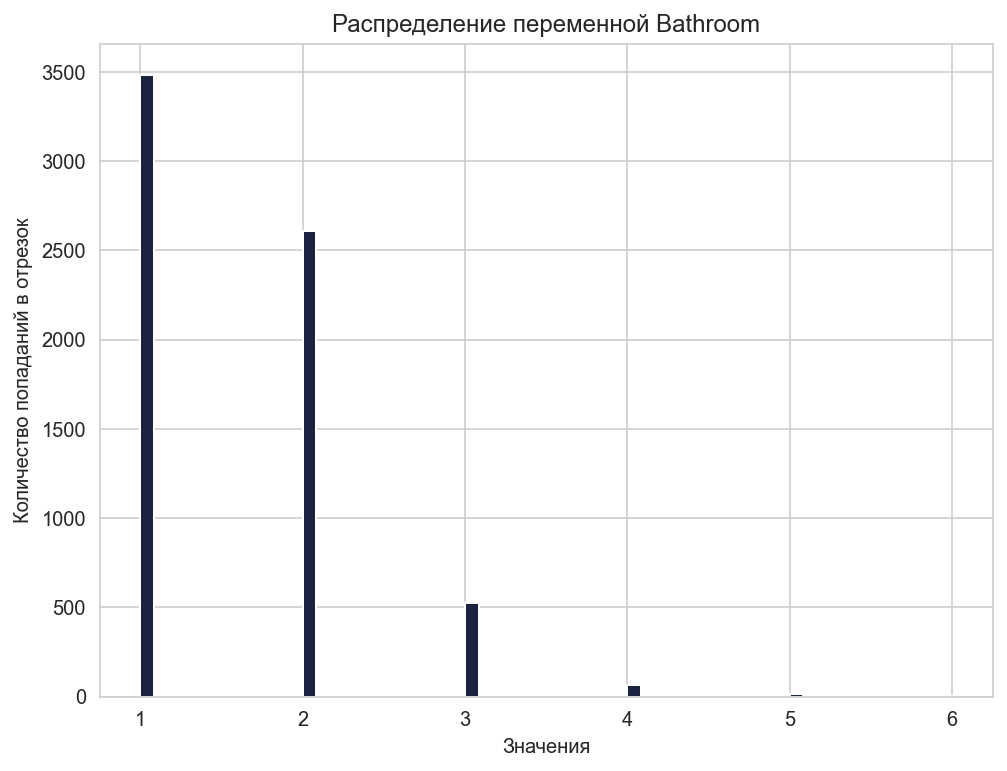

In [25]:
plot_hist(df, 'Bathroom') # количество ванных

In [26]:
len(df[df['Bathroom'] > 4]) # мало наблюдений, больших 4

19

In [27]:
df = df[df['Bathroom'] <= 4] # оставляем только те объекты, для которых значение Bathroom <= 4

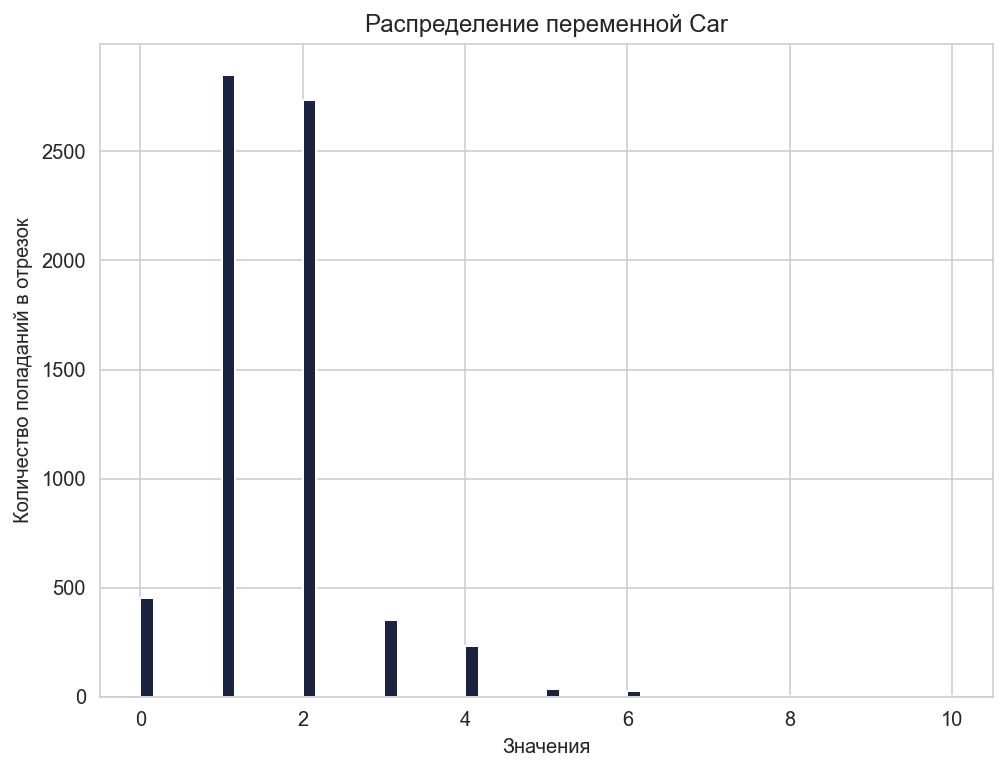

In [28]:
plot_hist(df, 'Car') # количество парковочных мест

In [29]:
len(df[df['Car'] > 6]) # мало наблюдений, больших 6

9

In [30]:
df = df[df['Car'] <= 6] # оставляем только те объекты, для которых значение Car <= 6

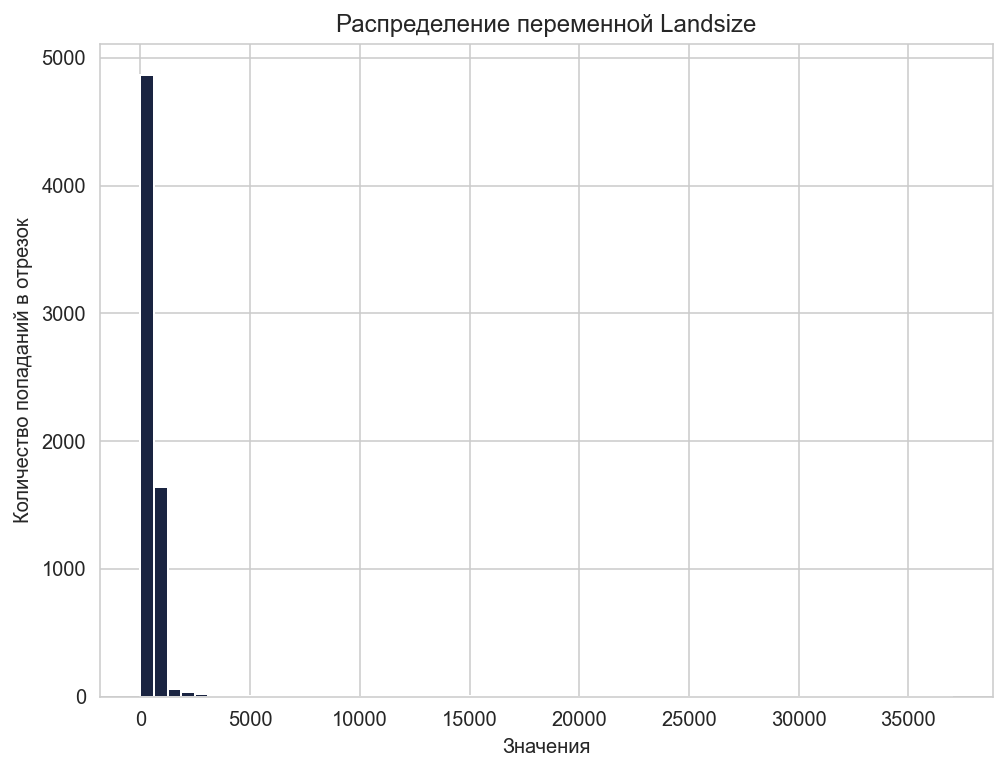

In [31]:
plot_hist(df, 'Landsize') # площадь земли

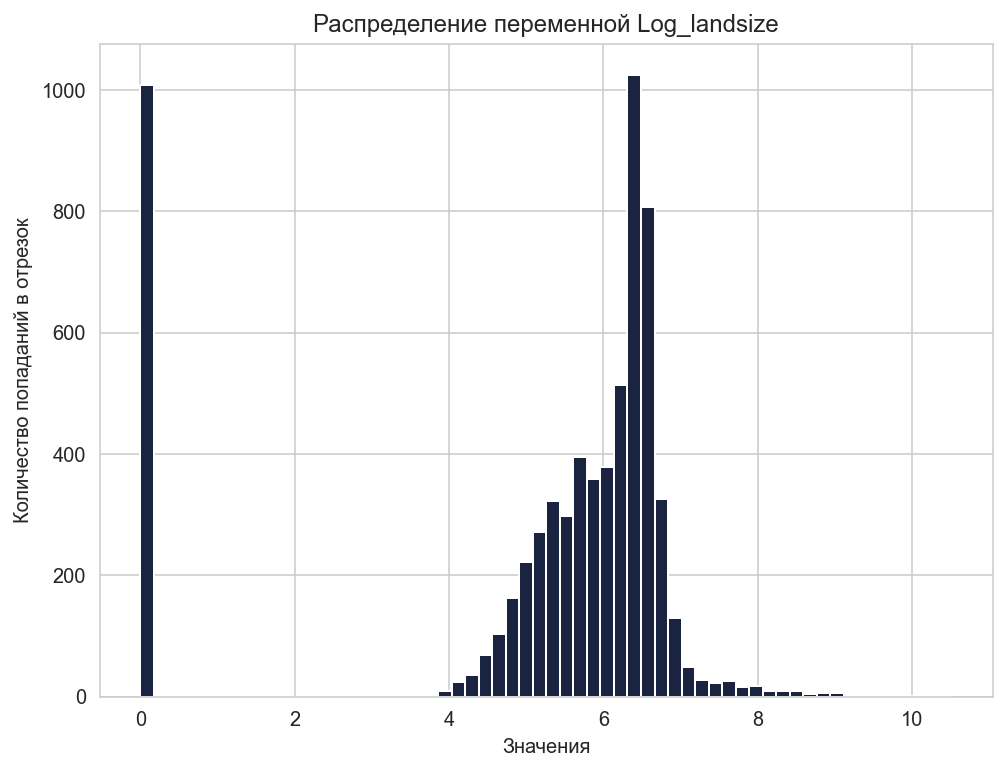

In [32]:
df['Log_landsize'] = np.log1p(df['Landsize']) # логарифмируем, добавляя единичку, т.е. делаем ln(1 + X)
plot_hist(df, 'Log_landsize') # логарифм площади земли

Есть объекты, для которых площадь земли равна нулю. Скорее всего, это многоквартирные дома, где человек покупает квартиру без земельного участка. Распределение ненулевых значений стало похожим на нормальное, стоит создать логарифм переменной.

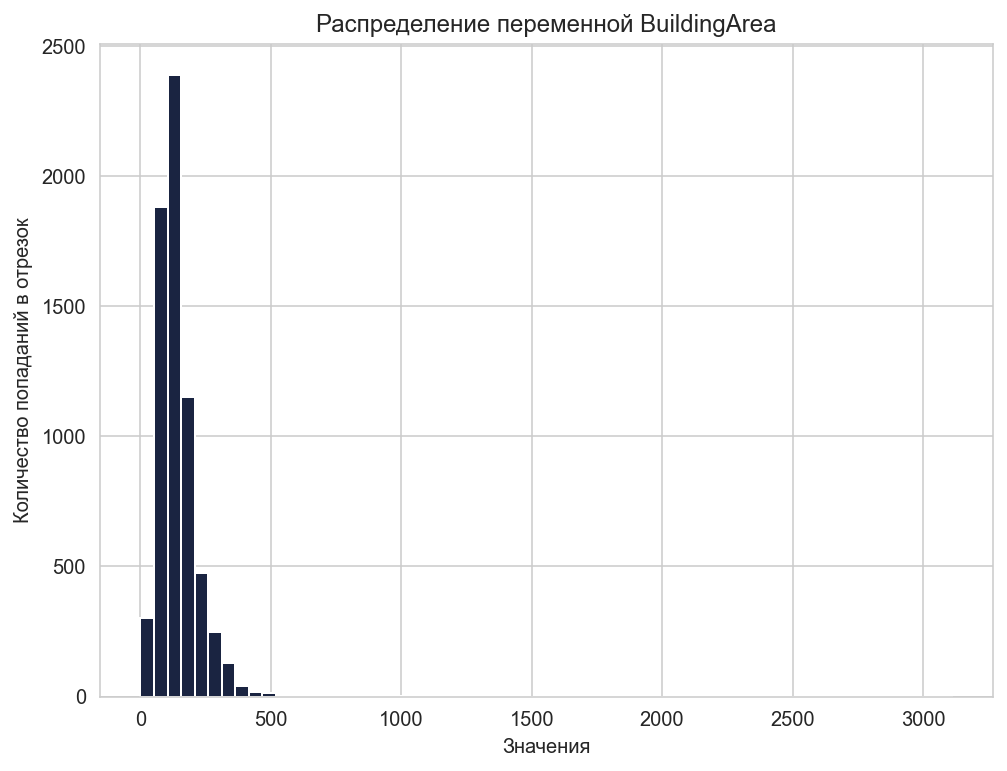

In [33]:
plot_hist(df, 'BuildingArea') # площадь жилья

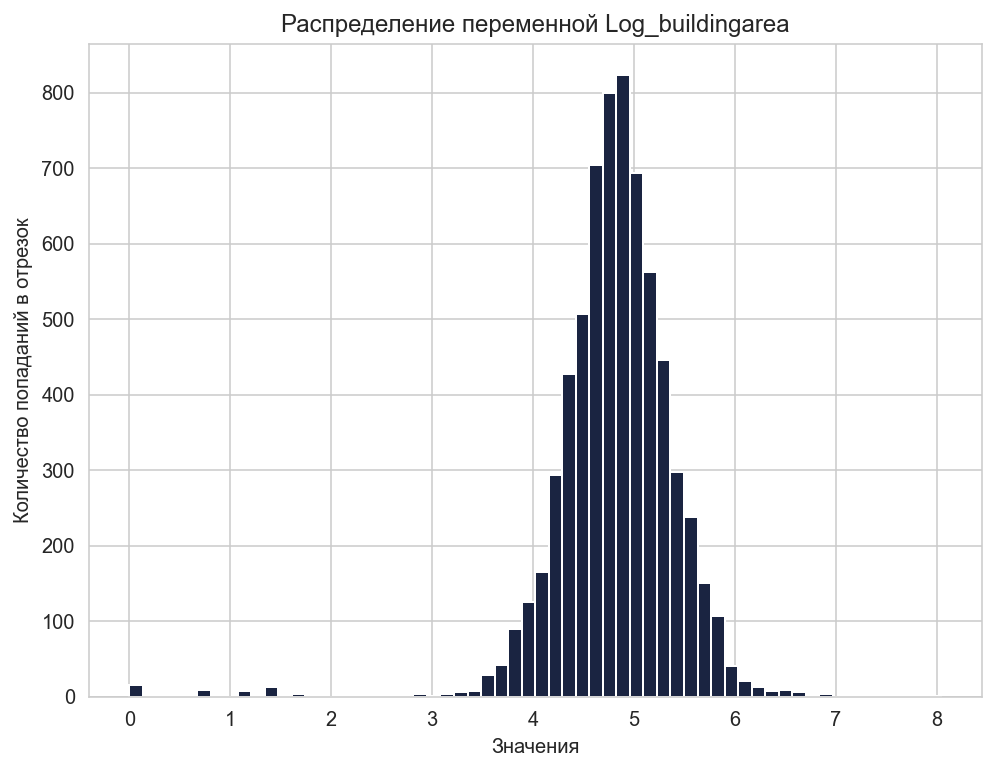

In [34]:
df['Log_buildingarea'] = np.log1p(df['BuildingArea']) # логарифмируем, добавляя единичку, т.е. делаем ln(1 + X)
plot_hist(df, 'Log_buildingarea') # логарифм площади жилья

Распределение стало похоже на нормальное, переменную лучше логарифмировать. Также удалим выбросы.

In [35]:
len(df[df['Log_buildingarea'] < 3]) # мало наблюдений, меньших 3

59

In [36]:
df = df[df['Log_buildingarea'] >= 3]
# оставляем только те объекты, для которых значение Log_buildingarea >= 3

In [37]:
len(df[df['Log_buildingarea'] >= 7]) # мало наблюдений, больших или равных 7

2

In [38]:
df = df[df['Log_buildingarea'] < 7] 
# оставляем только те объекты, для которых значение Log_buildingarea < 7

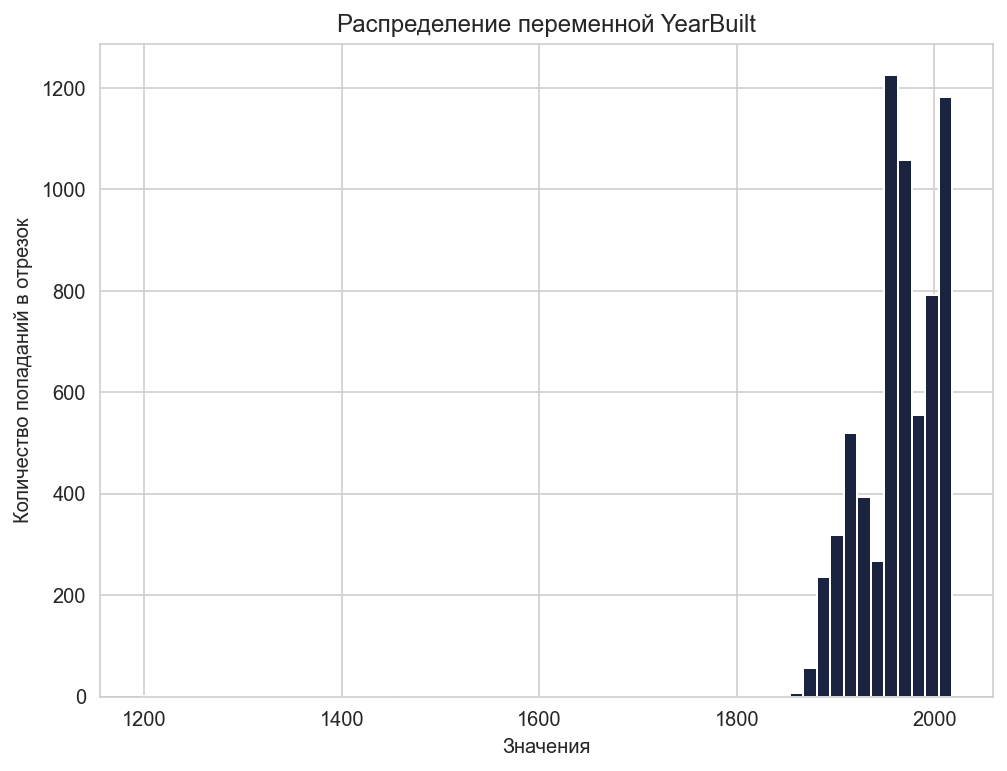

In [39]:
plot_hist(df, 'YearBuilt') # год постройки

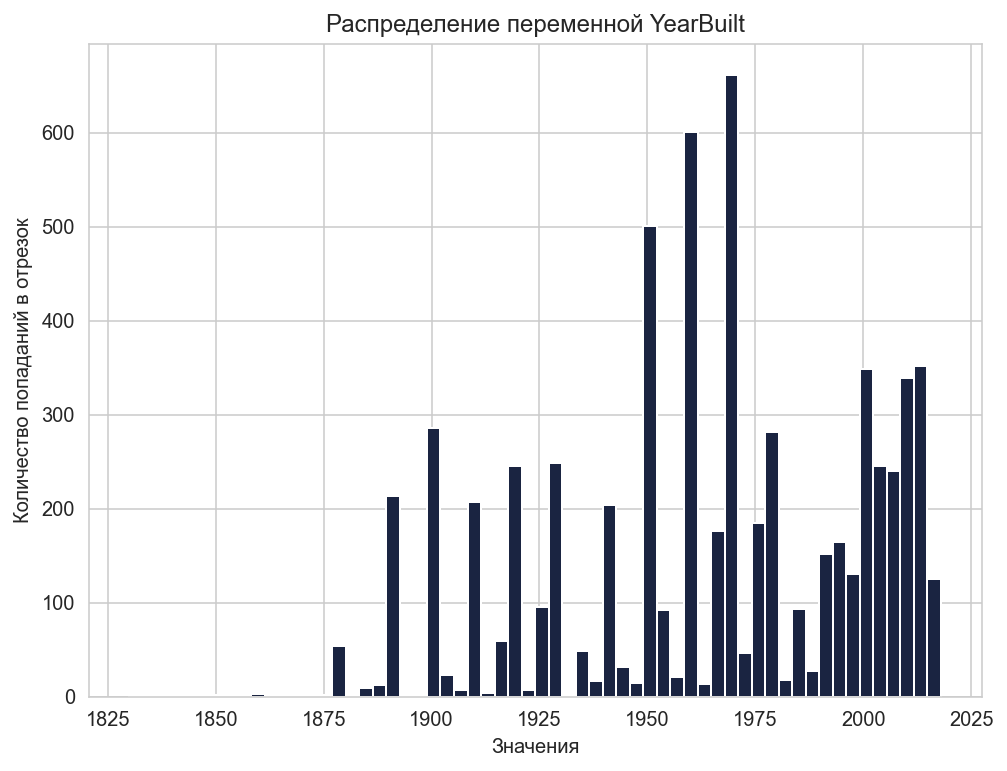

In [40]:
df = df[df['YearBuilt'] > 1800] # оставляем только те объекты, для которых значение YearBuilt > 1800
plot_hist(df, 'YearBuilt') # год постройки после удаления части значений

In [41]:
df = df[df['YearBuilt'] > 1875] # оставляем только те объекты, для которых значение YearBuilt > 1875

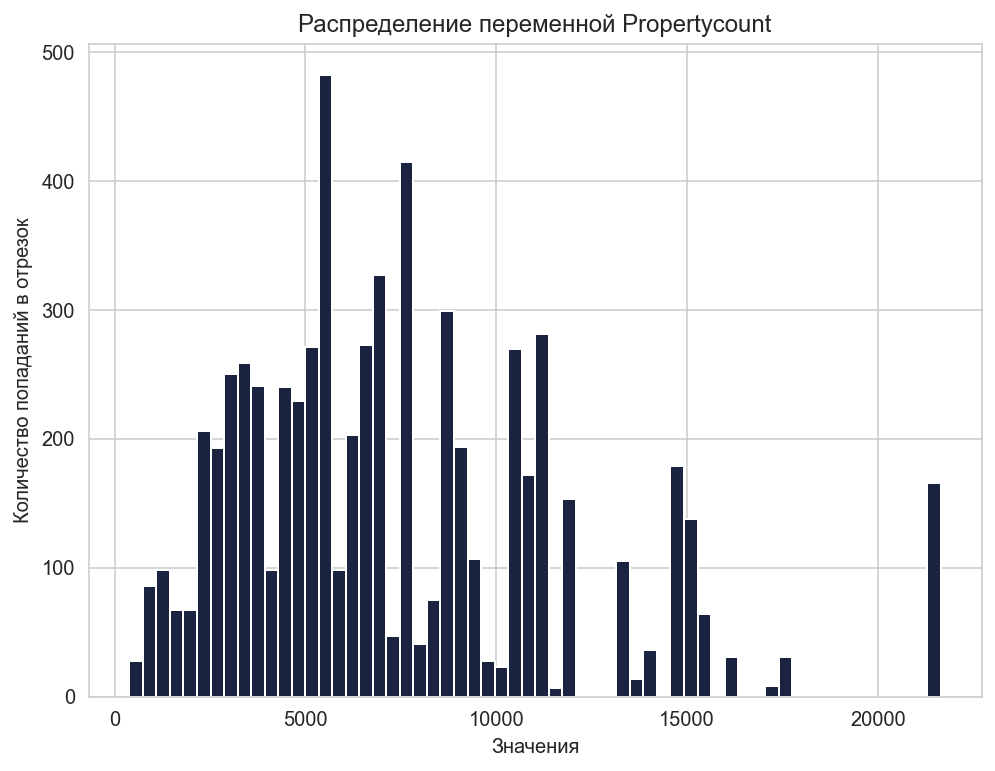

In [42]:
plot_hist(df, 'Propertycount') # количество объектов собственности в округе

In [43]:
df.shape # размерность данных после удаления выбросов

(6600, 19)

In [44]:
num = ['Rooms', 'Distance', 'Bedroom2', 'Bathroom', 'Car', 'YearBuilt',
       'Propertycount', 'Log_landsize', 'Log_buildingarea', 'Log_price']
# заменяем некоторые переменные на их логарифмы в списке числовых признаков

In [45]:
df = df[cat + num + fictive] # вносим эти изменения в датасет

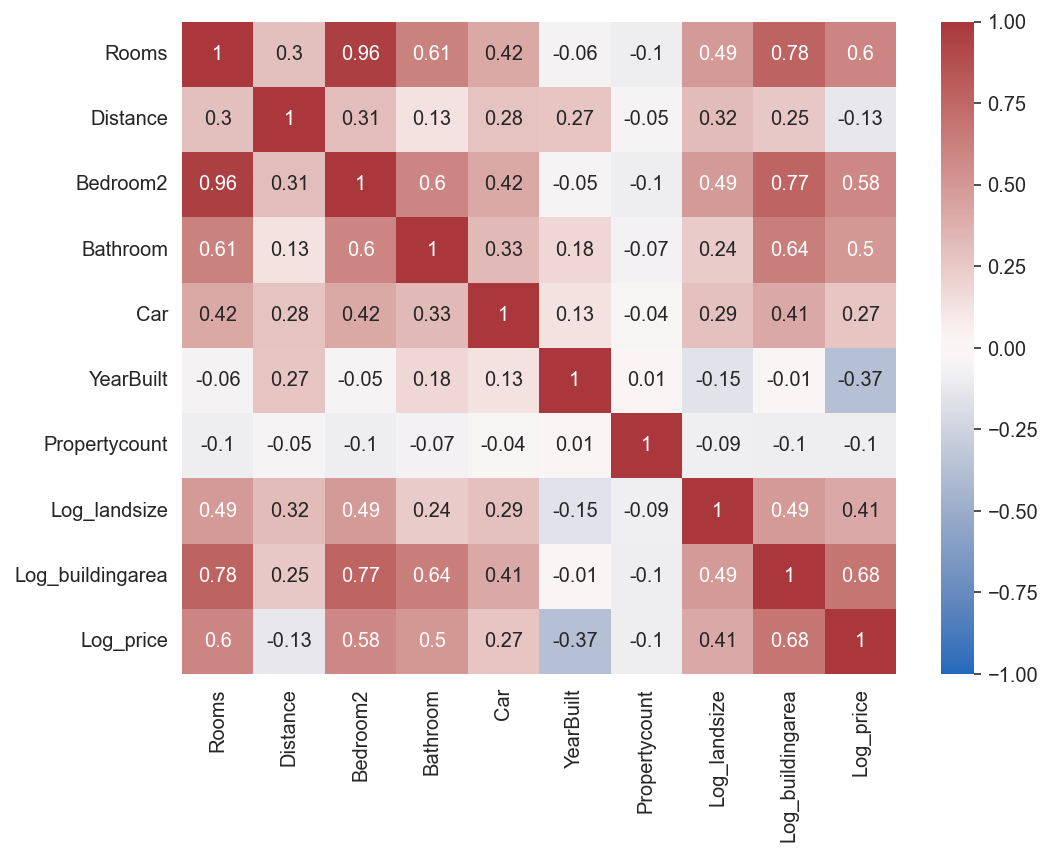

In [46]:
# корреляционная матрица
sns.heatmap(df[cat + num].corr().round(2), # матрица корреляций, значения округлили до двух знаков после запятой
            vmin=-1, # нижнее значение цветовой полосы справа (-1)
            vmax=1, # верхнее значение цветовой полосы справа (1)
            annot=True, # подписывать значения корреляций в ячейках
            cmap='vlag'); # цветовая палитра

Переменные, которые характеризуют общее число комнат и число спален сильно коррелируют друг с другом (корреляция равна 0,96 - почти 1). Удалим одну из них (количество спален), чтобы переменные в модели были независимыми.

In [47]:
df.drop(columns=['Bedroom2'], inplace=True) # удаляем переменную из данных
num.remove('Bedroom2') # удаляем переменную из списка 

In [48]:
to_int = ['Car', 'YearBuilt', 'Propertycount',
          'Rooms', 'Bathroom'] # переменные, которые должны быть int, а не float
df[to_int] = df[to_int].astype(int) # переводим их из вещественных в целочисленные

In [49]:
df.head() # очищенные данные, которые мы будем исследовать

,Type,Method,Regionname,Rooms,Distance,Bathroom,Car,YearBuilt,Propertycount,Log_landsize,Log_buildingarea,Log_price,Date,Lattitude,Longtitude
1,h,S,Northern Metropolitan,2,2.5,1,0,1900,4019,5.056246,4.382027,13.849913,4/02/2016,-37.8079,144.9934
2,h,SP,Northern Metropolitan,3,2.5,2,0,1900,4019,4.905275,5.017280,14.197366,4/03/2017,-37.8093,144.9944
4,h,VB,Northern Metropolitan,4,2.5,1,2,2014,4019,4.795791,4.962845,14.285515,4/06/2016,-37.8072,144.9941
6,h,S,Northern Metropolitan,3,2.5,2,0,1910,4019,5.505332,5.351858,14.444653,7/05/2016,-37.8024,144.9993
7,h,S,Northern Metropolitan,2,2.5,1,2,1890,4019,5.549076,4.682131,14.307765,8/10/2016,-37.8060,144.9954


In [50]:
df.shape # итоговая размерность данных 

(6600, 15)

In [51]:
df[num].describe().round(2) # описательные статистики
# все значения округляем до 2 знаков после запятой

,Rooms,Distance,Bathroom,Car,YearBuilt,Propertycount,Log_landsize,Log_buildingarea,Log_price
count,6600.00,6600.00,6600.00,6600.00,6600.00,6600.00,6600.00,6600.00,6600.00
mean,2.96,9.90,1.58,1.59,1964.28,7454.84,5.12,4.85,13.74
std,0.95,5.47,0.68,0.91,36.38,4348.19,2.26,0.48,0.54
min,1.00,0.00,1.00,0.00,1877.00,389.00,0.00,3.09,11.78
25%,2.00,6.10,1.00,1.00,1940.00,4407.00,5.11,4.55,13.36
50%,3.00,9.20,1.00,2.00,1970.00,6567.00,5.99,4.84,13.70
75%,4.00,12.90,2.00,2.00,1999.25,10331.00,6.45,5.15,14.10
max,6.00,38.00,4.00,6.00,2018.00,21650.00,10.52,6.95,16.01


## Визуализация данных (часть 1)

### 1. Тип жилья

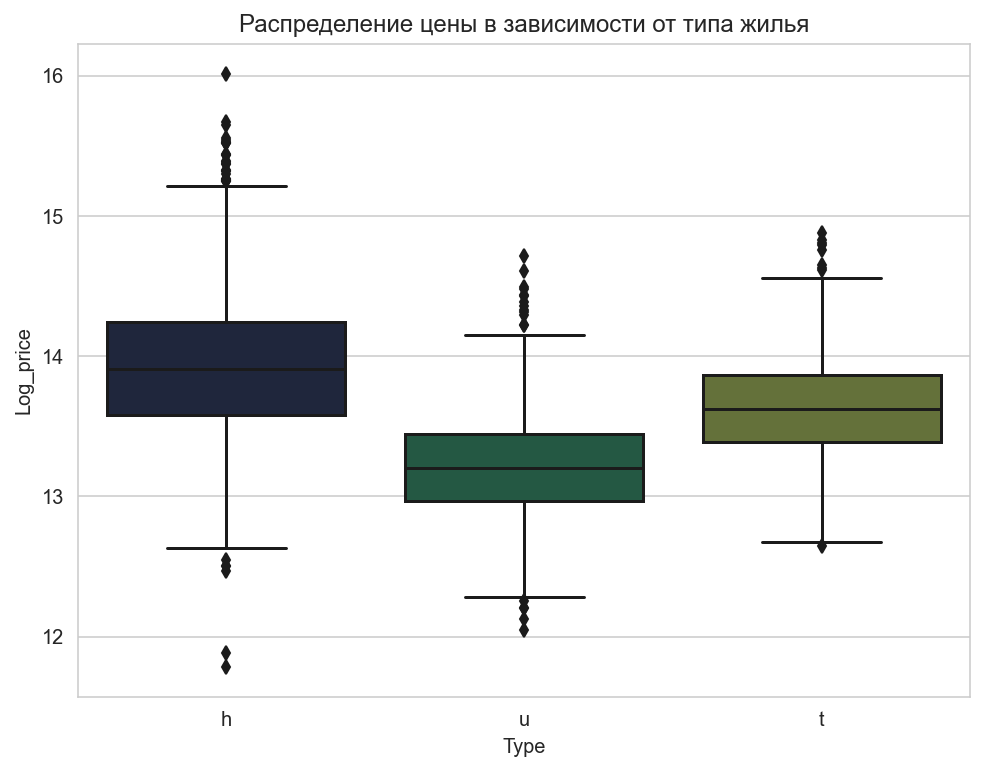

In [52]:
sns.boxplot(data=df, x='Type', y='Log_price') # ящики с усами
plt.title('Распределение цены в зависимости от типа жилья'); # заголовок

__Гипотеза 1:__ для категорий переменной Type попарно наблюдается разница в средних

__Содержательный смысл:__ если для разных типов жилья наблюдается статистическая разница средних значений цен, то стоит в дальнейшем визуализировать некоторые другие переменные в зависимости от типа жилья, что поможет создать новые признаки (например, произведения дамми на конкретный тип жилья и дамми на категорию другой переменной)

### 2. Регион

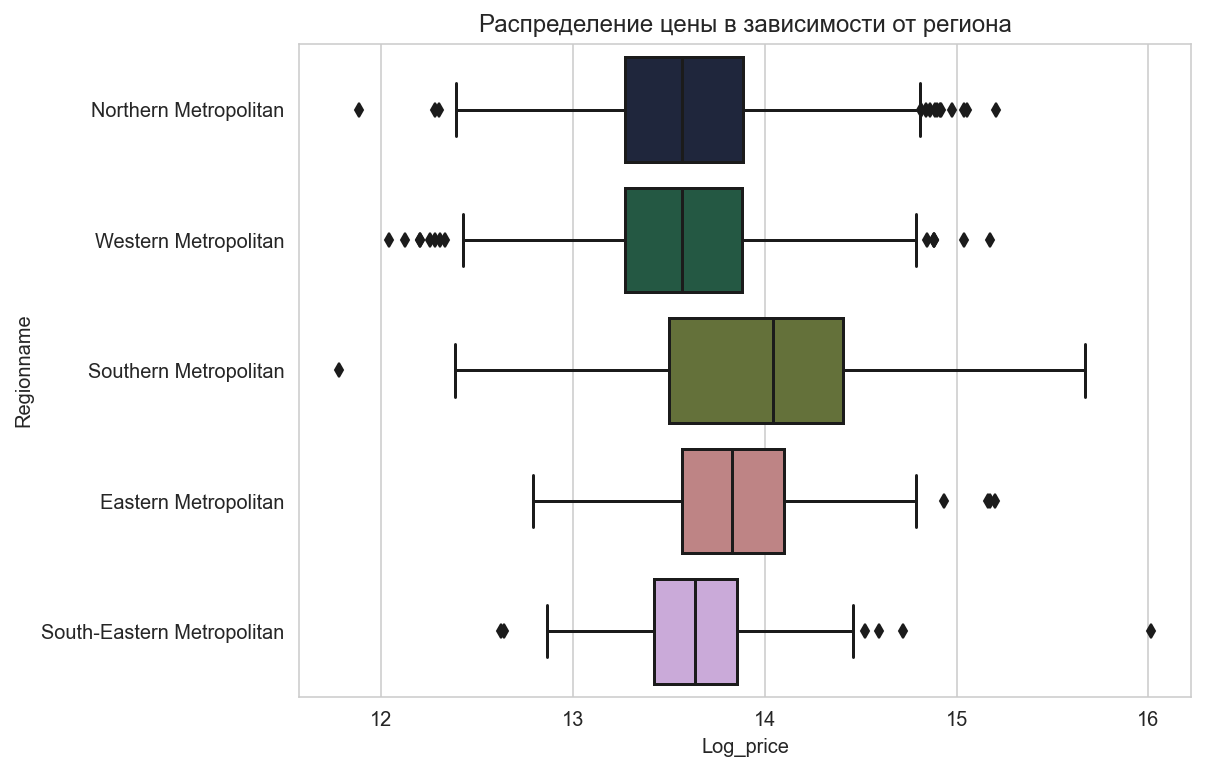

In [53]:
sns.boxplot(data=df, x='Log_price', y='Regionname') # ящики с усами
plt.title('Распределение цены в зависимости от региона'); # заголовок

__Гипотеза 2:__ среднее по Southern Metropolitan больше среднего по другим регионам

__Содержательный смысл:__ если цены на жилье в Southern Metropolitan в среднем выше, чем цены в других регионах, то стоит ввести переменную, которая характеризует расстояние от помещения до какого-то крупного объекта в Southern Metropolitan (например, там есть вокзал Southern Cross)

### 3. Год постройки

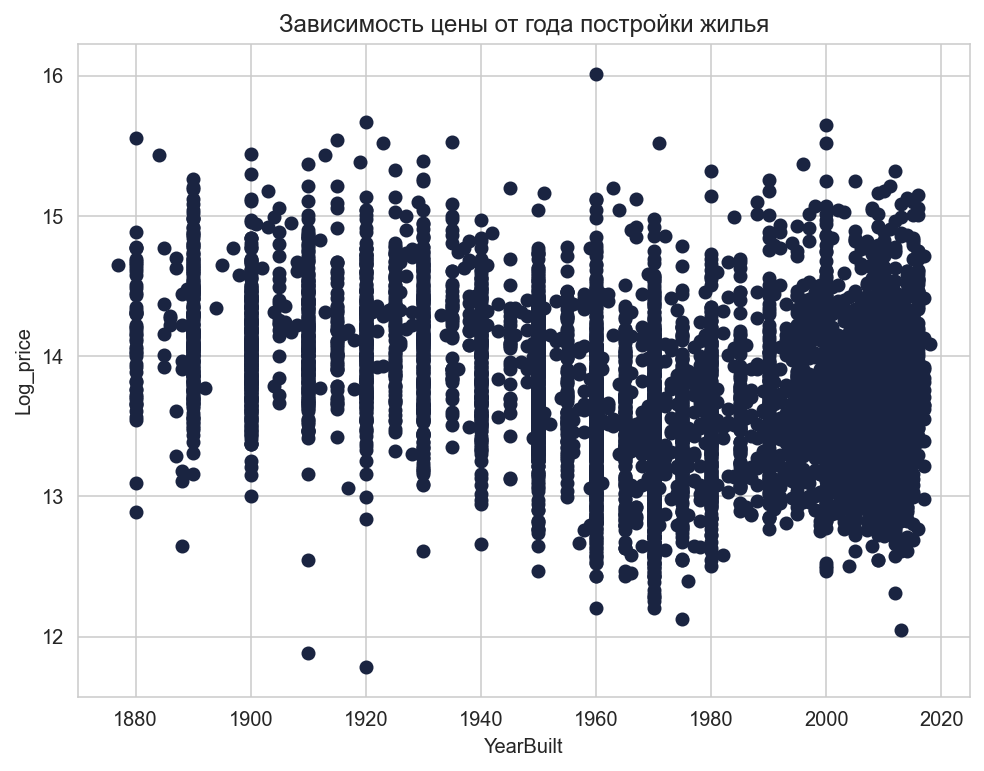

In [54]:
plt.scatter(data=df, x='YearBuilt', y='Log_price'); # диаграмма рассеяния
plt.xlabel('YearBuilt') # подпись горизонтальной оси
plt.ylabel('Log_price') # подпись вертикальной оси
plt.title('Зависимость цены от года постройки жилья'); # заголовок

__Наблюдение:__ цена зависит от года постройки полиномиально; следует включить квадрат и куб переменной YearBuilt

### 4. Расстояние до делового центра города

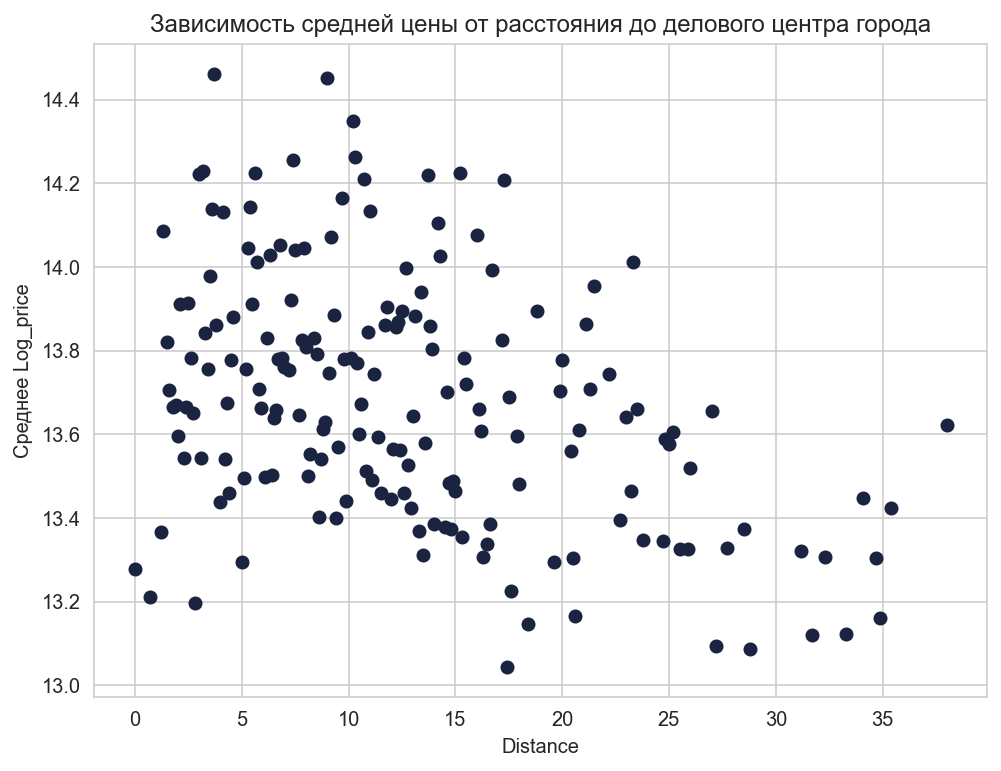

In [55]:
# группируем средние цен по значениям расстояния:
mean_price_by_dist = df.groupby('Distance').mean()['Log_price']
plt.scatter(mean_price_by_dist.index, mean_price_by_dist); # диаграмма рассеяния
plt.title('Зависимость средней цены от расстояния до делового центра города') # заголовок
plt.xlabel('Distance') # подпись горизонтальной оси
plt.ylabel('Среднее Log_price'); # подпись вертикальной оси

__Наблюдение:__ намечается зависимость, похожая на квадратичную (парабола с ветвями вниз) средней цены от расстояния: сначала цена резко возрастает, а затем плавно снижается; следует включить квадрат переменной Distance - аппроксимация параболой этой неизвестной зависимости. Можно сделать предположение о том, откуда берется такая зависимость: вблизи делового центра, скорее всего, находятся не самые пригодные для жилья помещения, а уже немного дальше что-то более пригодное для проживания, и как раз на такие помещения цена максимальная; чем дальше от центра, тем дешевле становится жилье.

### 5. Месяц покупки

In [56]:
df['Date'] = pd.to_datetime(df['Date']) # переводим Date в формат даты

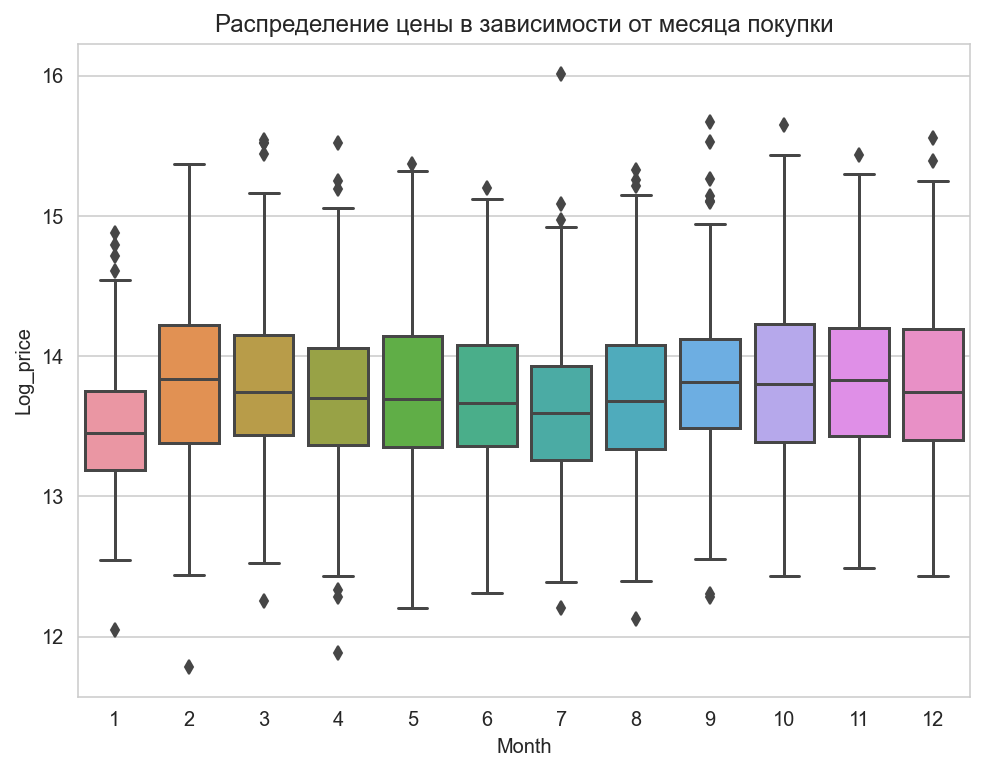

In [57]:
df['Month'] = df['Date'].dt.month # создаем колонку Месяц
sns.boxplot(data=df, x='Month', y='Log_price') # ящики с усами
plt.title('Распределение цены в зависимости от месяца покупки'); # заголовок

__Наблюдение:__ цена практически не зависит от месяца, в котором покупалось жилье, но можно посмотреть, зависит ли она от сезона

### 6. Сезон покупки

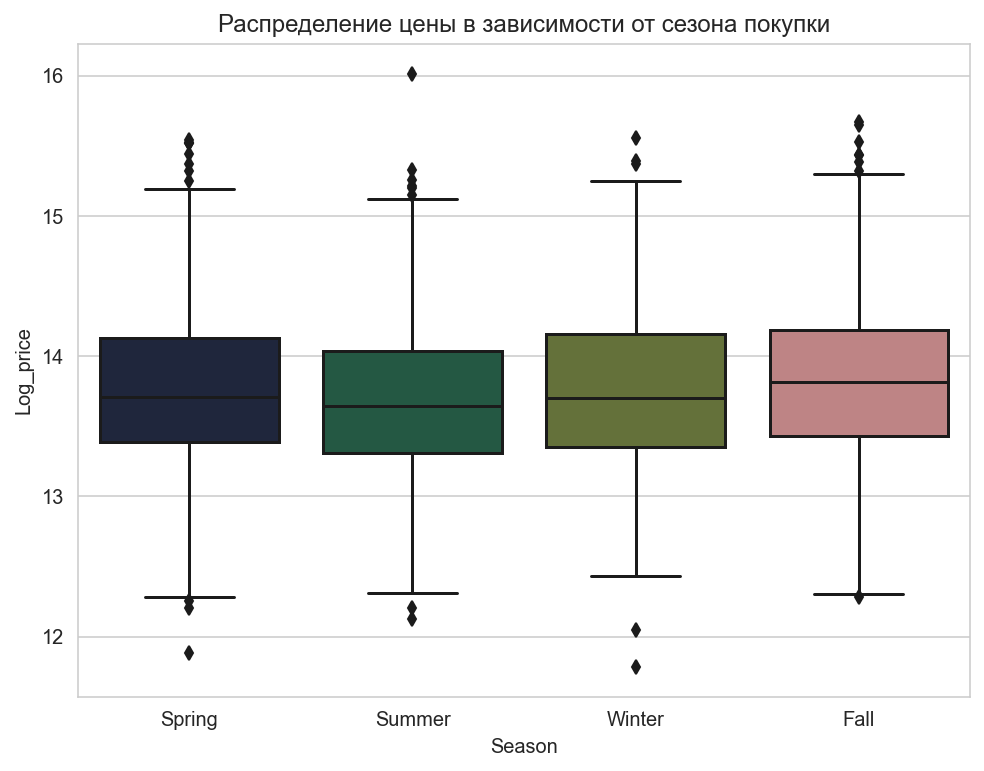

In [58]:
# создаем колонку Сезон (месяцы 12, 1, 2 - зима; 3, 4, 5 - весна и т.д.)
df['Season'] = np.where((df['Month']==12)|(df['Month']==1)|(df['Month']==2), 'Winter',
                        np.where((df['Month']==3)|(df['Month']==4)|(df['Month']==5), 'Spring',
                                 np.where((df['Month']==6)|(df['Month']==7)|(df['Month']==8), 'Summer', 'Fall')))
sns.boxplot(data=df, x='Season', y='Log_price') # ящики с усами
plt.title('Распределение цены в зависимости от сезона покупки'); # заголовок

__Наблюдение:__ от сезона цена также не зависит. Выводы, полученные в этом и предыдущем пунктах, полезны тем, что мы не станем бездумно включать в модель переменную "месяц покупки" или "сезон покупки", а значит не будем без пользы для результата увеличивать размерность данных (каждая категория = отдельная дамми-переменная)  

## Создание новых признаков (часть 1)

### 1. Полиномы переменной YearBuilt

In [59]:
df['YearBuilt_2'] = df['YearBuilt'] ** 2 # квадрат
df['YearBuilt_3'] = np.absolute(df['YearBuilt'] ** 3) # куб (без модуля везде отрицательные числа)

### 2. Квадрат переменной Distance

In [60]:
df['Distance_2'] = df['Distance'] ** 2

### 3. Уровень инфляции
Очевидно, цена жилья сильно зависит от уровня инфляции, на рынке недвижимости такая зависимость особенно ощутима. В качестве измерителя возьмем индекс потребительских цен в сфере недвижимости (Housing CPI) по данным Australian Bureau of Statistics (https://www.abs.gov.au/statistics/economy/price-indexes-and-inflation/consumer-price-index-australia) - они публикуются раз в квартал в процентном приросте относительно предыдущего месяца или того же квартала предыдущего года (нам подходит первый вариант). CPI для первого квартала в наших данных примем за единицу.

In [61]:
df['Date'].min() # минимальная дата

Timestamp('2016-03-09 00:00:00')

Минимальный квартал - январь-март 2016 года

In [62]:
df['Date'].max() # максимальная дата

Timestamp('2017-12-08 00:00:00')

Максимальный квартал - октябрь-декабрь 2017 года (итого 8 кварталов)

In [63]:
# цепные изменения CPI (данные взяты с сайта выше)
cpi = np.array([1, 1.004, 1.01, 1.003, 1.008, 1.003, 1.019, 1.003])

# базисные изменения CPI
cpi_cum = np.cumprod(cpi)

# столбец с годом в данных
df['Year'] = df['Date'].dt.year

# номера кварталов в данных
df['Qtr'] = np.where((df['Month']==1)|(df['Month']==2)|(df['Month']==3), 1,
                    np.where((df['Month']==4)|(df['Month']==5)|(df['Month']==6), 2,
                            np.where((df['Month']==7)|(df['Month']==8)|(df['Month']==9), 3, 4)))

# уникальный индекс каждого квартала (склеиваем год и номер квартала)
df['Qtr_index'] = df['Year'] * 10 + df['Qtr']

# полученные индексы - столбец новой таблицы с CPI по кварталам
qtr_ind = sorted(pd.unique(df['Qtr_index'])) # сортируем индексы
df_cpi = pd.DataFrame() # создаем таблицу
df_cpi['Qtr_index'] = qtr_ind # в колонку Qtr_index записываем индексы
df_cpi['CPI'] = cpi_cum # в колонку CPI записываем базисные изменения ИПЦ
df_cpi

,Qtr_index,CPI
0,20161,1.000000
1,20162,1.004000
2,20163,1.014040
3,20164,1.017082
4,20171,1.025219
5,20172,1.028294
6,20173,1.047832
7,20174,1.050976


In [64]:
# создаем столбец CPI в данных
df = df.merge(df_cpi, on='Qtr_index')

## Проверка гипотез

### 1. Гипотезы о попарных различиях в средних по категориям переменной Type

$$
\begin{aligned}
& H_0: \mu_{x} = \mu_{y} \\
& H_1: \mu_{x} \neq \mu_{y}
\end{aligned}
$$
Уровень значимости - 5%

In [65]:
h = df[df['Type']=='h']['Log_price'] # цена тех, где у Type значение h 
u = df[df['Type']=='u']['Log_price'] # цена тех, где у Type значение u
t = df[df['Type']=='t']['Log_price'] # цена тех, где у Type значение t

In [66]:
# h, u
# z_test_mu_diff_two_sided - авторская функция, вынесенная в отдельный блок
z_test_mu_diff_two_sided(h, u, 0.05)

'H0 отвергается'

In [67]:
# h, t
z_test_mu_diff_two_sided(h, t, 0.05)

'H0 отвергается'

In [68]:
# u, t
z_test_mu_diff_two_sided(u, t, 0.05)

'H0 отвергается'

__Наблюдение:__ между всеми типами жилья видна статистическая разница средних. В дальнейшем визуализируем переменные "Сезон" и "Месяц" отдельно по этим категориям (между ними не наблюдалось разницы, когда мы смотрели на все данные сразу): возможно, получится увидеть различия

### 2. Гипотеза о различиях в средних между ценами в Southern Metropolitan и другими регионами

$$
\begin{aligned}
& H_0: \mu_{x} = \mu_{y} \\
& H_1: \mu_{x} > \mu_{y}
\end{aligned}
$$
*Уровень значимости - 5%*

In [69]:
# цена тех, где регион Southern Metropolitan:
sm = df[df['Regionname']=='Southern Metropolitan']['Log_price']
# цена тех, где регион не Southern Metropolitan:
not_sm = df[df['Regionname']!='Southern Metropolitan']['Log_price']

In [70]:
# z_test_mu_diff_right_sided - авторская функция, вынесенная в отдельный блок
z_test_mu_diff_right_sided(sm, not_sm, 0.05) # тестируем гипотезу

'H0 отвергается'

__Наблюдение:__ в Southern Metropolitan средняя цена жилья статистически больше, чем в других регионах. В дальнейшем введем переменную, которая характеризует расстояние от вокзала Southern Cross, расположенного в этом регионе, до каждого помещения. Вокзал был выбран в качестве ориентира, так как это, во-первых, крупный и значимый объект, а во-вторых, он означает транспортную доступность для тех, кто живет поблизости.

## Визуализация данных (часть 2)

In [71]:
df_h = df[df['Type']=='h'] # данные по тем, где у Type значение h
df_u = df[df['Type']=='u'] # данные по тем, где у Type значение u
df_t = df[df['Type']=='t'] # данные по тем, где у Type значение t

### 1. Месяц покупки
#### Категория h

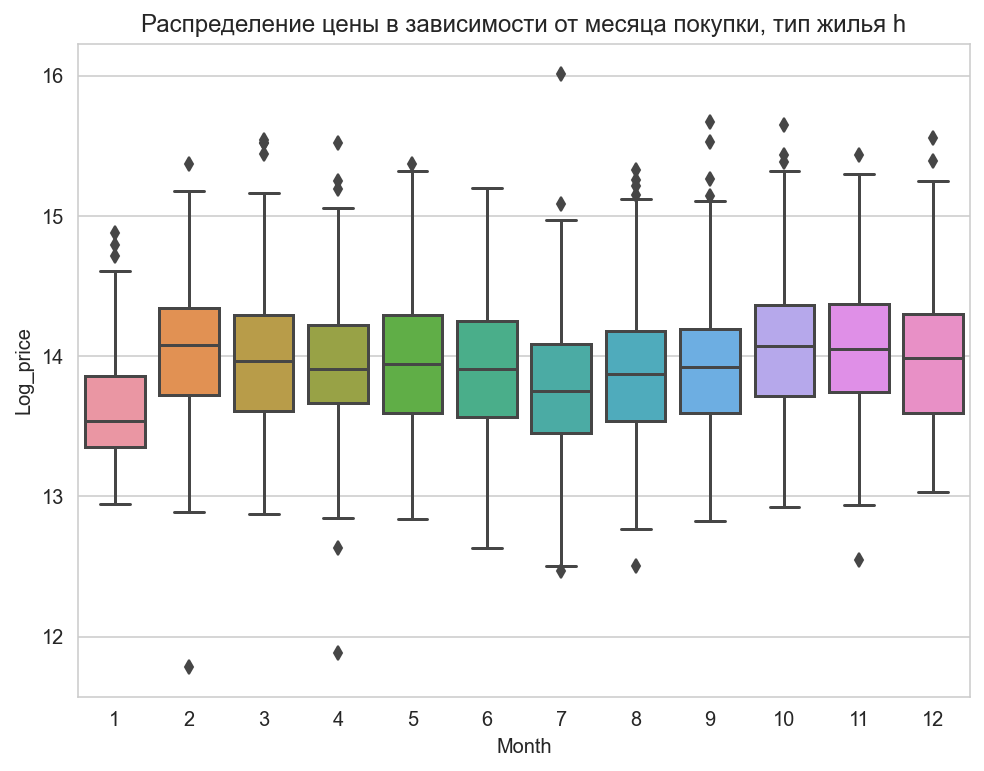

In [72]:
sns.boxplot(data=df_h, x='Month', y='Log_price') # ящики с усами
plt.title('Распределение цены в зависимости от месяца покупки, тип жилья h'); # заголовок

__Наблюдение:__ это категория, которая характеризует дома и виллы, и в ней очень выбивается январь (цены сильно ниже, чем в другие месяцы). В дальнейшем создадим категорию "тип жилья h и месяц январь" - произведение соответствующих дамми-переменных

#### Категория u

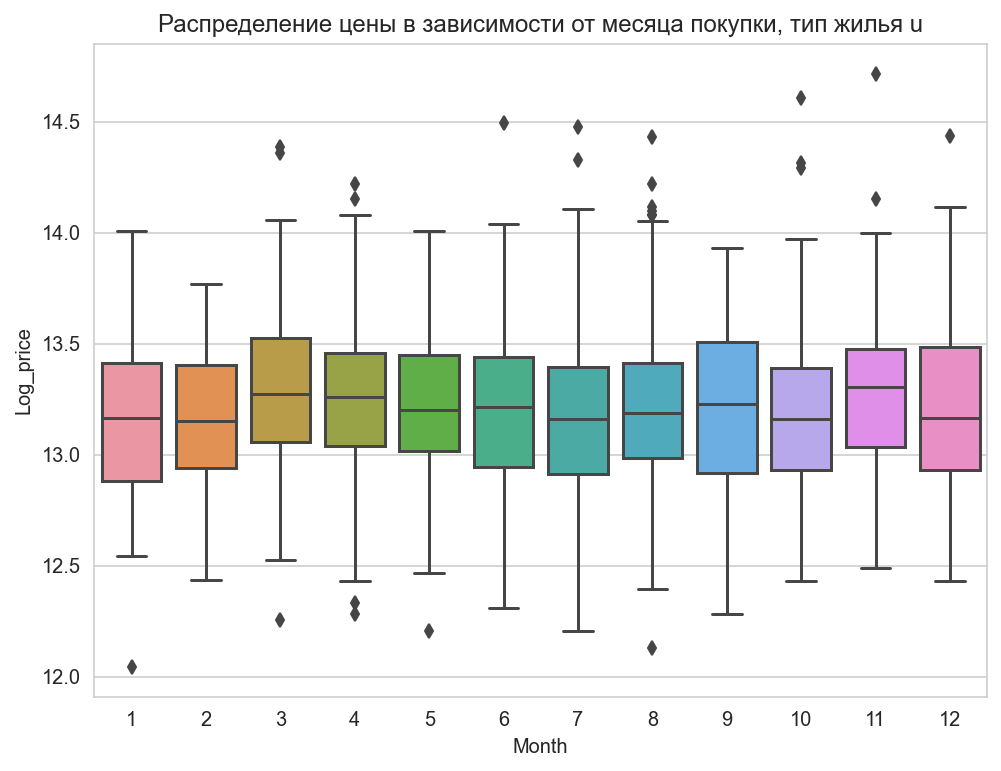

In [73]:
sns.boxplot(data=df_u, x='Month', y='Log_price') # ящики с усами
plt.title('Распределение цены в зависимости от месяца покупки, тип жилья u'); # заголовок

__Наблюдение:__ это категория, которая характеризует блоки, и в ней не наблюдается сильной разницы между месяцами

#### Категория t

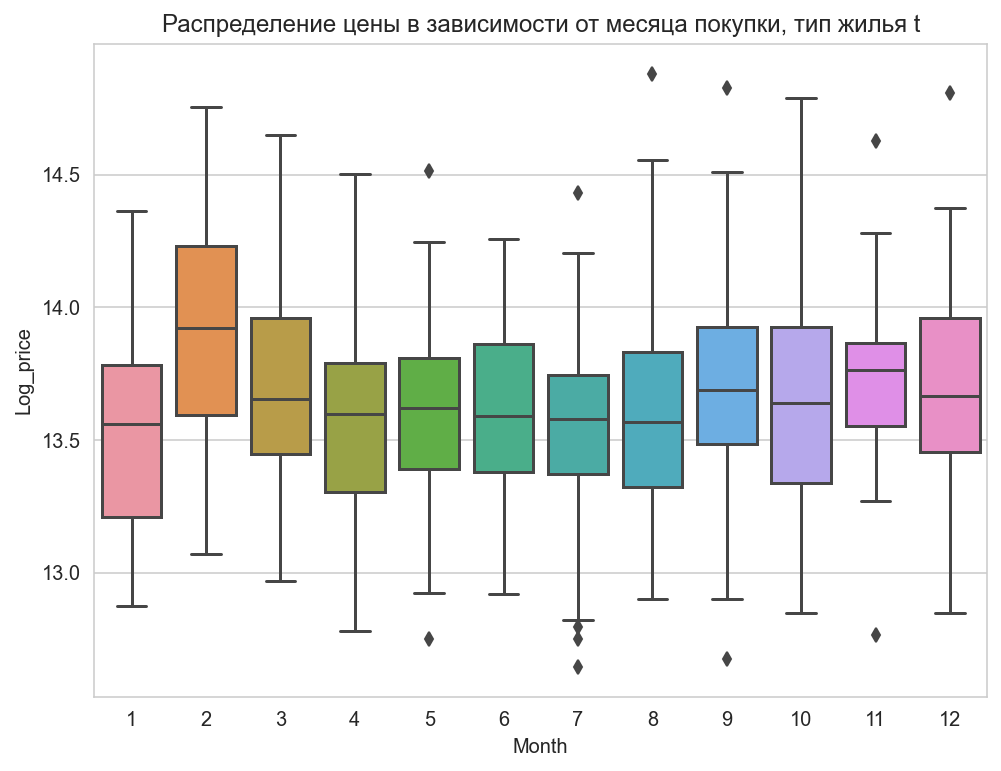

In [74]:
sns.boxplot(data=df_t, x='Month', y='Log_price') # ящики с усами
plt.title('Распределение цены в зависимости от месяца покупки, тип жилья t'); # заголовок

__Наблюдение:__ это категория, которая характеризует таунхаусы, и в ней очень выбивается февраль (цены сильно выше, чем в другие месяцы). В дальнейшем создадим категорию "тип жилья t и месяц февраль" - произведение соответствующих дамми-переменных

### 2. Сезон покупки
#### Категория h

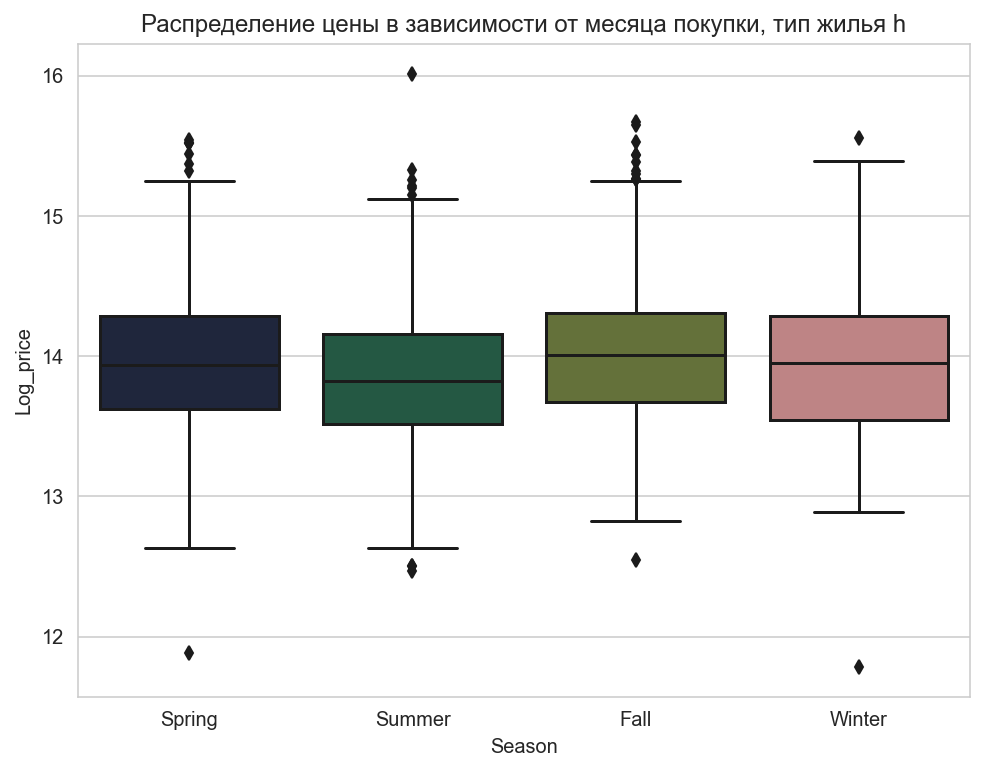

In [75]:
sns.boxplot(data=df_h, x='Season', y='Log_price') # ящики с усами
plt.title('Распределение цены в зависимости от месяца покупки, тип жилья h');  # заголовок

#### Категория u

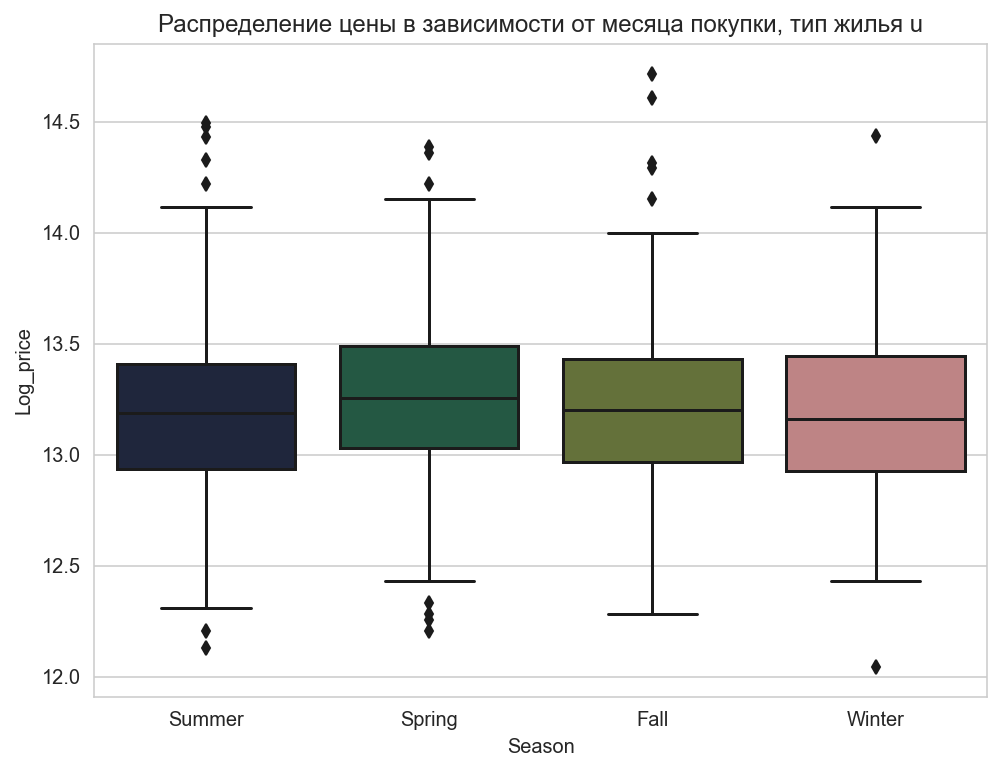

In [76]:
sns.boxplot(data=df_u, x='Season', y='Log_price') # ящики с усами
plt.title('Распределение цены в зависимости от месяца покупки, тип жилья u');  # заголовок

#### Категория t

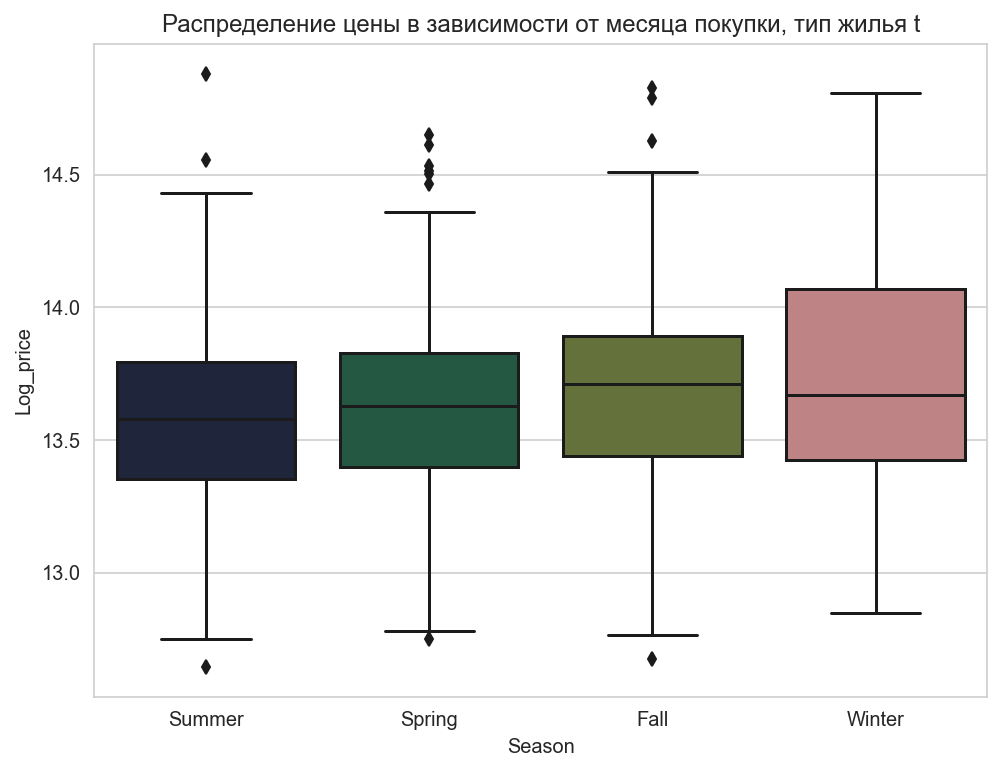

In [77]:
sns.boxplot(data=df_t, x='Season', y='Log_price') # ящики с усами
plt.title('Распределение цены в зависимости от месяца покупки, тип жилья t');  # заголовок

__Наблюдение:__ в сезонах по категориям жилья особых различий не видно

## Создание новых признаков (часть 2)

### 1. Расстояние до Southern Cross

In [78]:
sc_lat = [-37.818285] * len(df) # столбец со значением широты Southern Cross
sc_long = [144.952776] * len(df) # столбец со значением долготы Southern Cross

# manhattan_distance - авторская функция, вынесенная в отдельный блок
df['SC_Distance'] = manhattan_distance(df,
                                       # широта и долгота каждого помещения:
                                       df['Lattitude'], df['Longtitude'],
                                       # широта и долгота Southern Cross:
                                       sc_lat, sc_long)

### 2. Тип жилья h и месяц январь

In [79]:
dummy_h = (df['Type'] == 'h').astype(int) # дамми на тип жилья h
dummy_jan = (df['Month'] == 1).astype(int) # дамми на январь
df['Jan_h'] = dummy_jan * dummy_h # перемножаем эти дамми

### 3. Тип жилья t и месяц февраль

In [80]:
dummy_t = (df['Type'] == 't').astype(int) # дамми на тип жилья t
dummy_feb = (df['Month'] == 2).astype(int) # дамми на февраль
df['Feb_t'] = dummy_feb * dummy_t # перемножаем эти дамми

## Итоговая витрина данных

In [81]:
# оставляем только те признаки, которые нужны для модели (без вспомогательных):
df = df[['Type', 'Method', 'Regionname', 'Rooms', 'Bathroom', 'Car',
         'Distance', 'Distance_2', 'YearBuilt', 'YearBuilt_2', 'YearBuilt_3',
         'Propertycount', 'Log_landsize', 'Log_buildingarea',
         'CPI', 'SC_Distance', 'Jan_h', 'Feb_t', 'Log_price']]
df.head()

,Type,Method,Regionname,Rooms,Bathroom,Car,Distance,Distance_2,YearBuilt,YearBuilt_2,YearBuilt_3,Propertycount,Log_landsize,Log_buildingarea,CPI,SC_Distance,Jan_h,Feb_t,Log_price
0,h,S,Northern Metropolitan,2,1,0,2.5,6.25,1900,3610000,1730934592,4019,5.056246,4.382027,1.004,4.723659,0,0,13.849913
1,h,VB,Northern Metropolitan,4,1,2,2.5,6.25,2014,4056196,420755848,4019,4.795791,4.962845,1.004,4.863026,0,0,14.285515
2,u,S,Northern Metropolitan,2,1,1,2.5,6.25,1970,3880900,944561592,4019,0.000000,4.110874,1.004,5.769483,0,0,13.122365
3,h,PI,Northern Metropolitan,2,2,1,2.5,6.25,2013,4052169,432918395,4019,4.828314,4.912655,1.004,5.101422,0,0,13.910822
4,h,S,Northern Metropolitan,2,1,0,2.5,6.25,1900,3610000,1730934592,4019,5.209486,4.418841,1.004,5.737878,0,0,13.827934


In [82]:
# непрерывные переменные
num = ['Rooms', 'Bathroom', 'Car', 'Distance', 'Distance_2',
       'YearBuilt', 'YearBuilt_2', 'YearBuilt_3',
       'Propertycount', 'Log_landsize', 'Log_buildingarea',
       'CPI', 'SC_Distance']
# категориальные переменные
cat = ['Type', 'Method', 'Regionname', 'Jan_h', 'Feb_t']

In [83]:
# сохраняем очищенные данные в отдельный файл
df.to_csv('data_cleared.csv', index=False)

## Машинное обучение

Зависимая переменная, которую логично предсказывать - цена жилья (в нашем случае - ее логарифм). С помощью полученной модели можно определять, сколько примерно будет стоит жилье с определенным набором характеристик, при этом можно сделать достаточно реалистичный прогноз в настоящем времени, так как в модели есть переменная, характеризующая уровень цен. Очевидно, мы решаем задачу регрессии, так как зависимая переменная непрерывная. Будем использовать MSE (mean squared error, среднеквадратическую ошибку), так как данные очищены от выбросов (к которым она чувствительна) и у нее меньше проблем с обучением, чем на MAE (mean absolute error, средняя абсолютная ошибка).

### 1. Разбиение на обучающую и тестовую выборку

In [84]:
random_state = 1 # чтобы воспроизводились одни и те же результаты 

X = df.drop(columns=['Log_price']) # признаки
y = df['Log_price'] # зависимая переменная

# разбиваем на обучающую и тестовую выборку в пропорции 80% - 20%
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.8,
                                                    random_state=random_state)

### 2. Модель 1: наивный прогноз

In [85]:
best_constant = y_train.mean() # среднее значение целевой переменной на тестовой выборке
res_1 = mean_squared_error(y_test, best_constant * np.ones(y_test.shape)) # ошибка
print(np.round(res_1, 5))

0.27382


Это значение метрики будет использовано в качестве бенчмарка для оценки качества новых моделей.

### 3. Модель 2: линейная регрессия без регуляризации

In [86]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), cat), # дамми-переменные из категориальных
    ('scaling', StandardScaler(), num) # нормируем непрерывные переменные
])

model_lr = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer), # преобразуем колонки
    ('regression', LinearRegression()) # строим линейную регрессию
])

model_lr.fit(X_train, y_train) # обучаем модель
preds_lr = model_lr.predict(X_test) # получаем предсказания

res_2 = mean_squared_error(y_test, preds_lr) # ошибка на тестовой
print(np.round(res_2, 5))

0.05463


Ошибка на тестовой выборке очень сильно упала. Попробуем теперь сделать модель с регуляризацией и посмотреть, улучшится ли еще качество.

### 4. Модель 3: Ridge регрессия

In [87]:
model_ridge = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer), # преобразуем колонки
    ('regression', Ridge(random_state=random_state)) # строим Ridge регрессию
])

model_ridge.fit(X_train, y_train) # обучаем модель
preds_ridge = model_ridge.predict(X_test) # получаем предсказания

res_3 = mean_squared_error(y_test, preds_ridge) # ошибка на тестовой
print(np.round(res_3, 5))

0.05507


Ошибка на тестовой выборке немного выросла по сравнению с предыдущей моделью, но все равно гораздо ниже бенчмарка. Попробуем подобрать параметры с помощью кросс-валидации и посмотреть, улучшится ли модель.

### 5. Модель 4: Ridge регрессия с кросс-валидацией

In [88]:
alphas = np.logspace(-2, 3, 20) # набор параметров, которые мы переберем
searcher = GridSearchCV(Ridge(random_state=random_state), # модель
                        [{'alpha': alphas}], # набор параметров
                        scoring='neg_mean_squared_error', # целевая метрика
                        cv=10) # количество фолдов

X_scaled = column_transformer.fit_transform(X_train) # преобразуем данные
searcher.fit(X_scaled, y_train) # кросс-валидация

best_alpha = searcher.best_params_['alpha'] # лучший параметр
print('Best alpha:', np.round(best_alpha, 5))

Best alpha: 0.01


In [89]:
model_ridge_cv = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer), # преобразуем колонки
    ('regression', Ridge(alpha=best_alpha,
                         random_state=random_state)) # строим Ridge регрессию с кросс-вал.
])

model_ridge_cv.fit(X_train, y_train) # обучаем модель
preds_ridge_cv = model_ridge_cv.predict(X_test) # получаем предсказания

res_4 = mean_squared_error(y_test, preds_ridge_cv) # ошибка на тестовой
print(np.round(res_4, 5))

0.05537


Ошибка на тестовой выборке еще немного выросла по сравнению с предыдущими моделями, но осталась сильно ниже бенчмарка.

### 6. Сравнение результатов всех моделей

In [90]:
lr_results = [res_1, res_2, res_3, res_4] # создаем список из ошибок на всех моделях
pd.DataFrame(lr_results, # делаем из них табличку
             index=['Naive', 'LogReg', 'Ridge', 'Ridge_with_CV'], # индексы - названия моделей
             columns=['MSE']) # колонки - название метрики

,MSE
Naive,0.273817
LogReg,0.054634
Ridge,0.055068
Ridge_with_CV,0.055374


Самую маленькую ошибку мы получили, построив обычную регрессию без регуляризации и кросс-валидации. Посмотрим на ее самые большие по модулю отрицательные коэффициенты:

In [91]:
coefs_lr = model_lr.named_steps['regression'].coef_ 
sorted(coefs_lr)[:5]

[-640.5088421166075,
 -322.15775035429397,
 -0.2635196427403577,
 -0.2136064928531515,
 -0.20824947970794278]

А теперь на самые большие по модулю положительные коэффициенты:

In [92]:
sorted(coefs_lr)[-5:]

[0.21809513240976583,
 318.28948112070486,
 1171987984695.199,
 1171987984695.3545,
 1171987984695.4805]

Видно, что крайние левые и правые значения коэффициентов аномально большие, что свидетельствует о переобучении модели, а значит ее нельзя считать хорошей.

Следующая по качеству модель - Ridge регрессия на дефолтных параметрах. Посмотрим на ее крайние левые значения коэффициентов:

In [93]:
coefs_ridge = model_ridge.named_steps['regression'].coef_
sorted(coefs_ridge)[:5]

[-0.5697367865270597,
 -0.5160548390700397,
 -0.2589104378380945,
 -0.217417097201373,
 -0.20542371985883015]

И на крайние правые:

In [94]:
sorted(coefs_ridge)[-5:]

[0.09160129440940513,
 0.13528040953301138,
 0.16834374176721478,
 0.1931282184821993,
 0.2144297343091051]

Видно, насколько меньше эти значения по сравнению с предыдущим случаем. Модель работает адекватно и демонстрирует достаточно небольшое значение ошибки. Посчитаем его в процентном приросте относительно бенчмарка:

In [95]:
np.round(((res_3 - res_1) / res_1) * 100, 1)

-79.9

Итак, благодаря модели получилось снизить ошибку почти на 80%. Оставим эту модель в качестве итоговой.